In [2]:
#%matplotlib widget
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time


In [3]:
def update(state,control,dt):
    noise = np.random.normal(0, 0.001, size=state.shape)
    return state+(control*dt)+noise


In [4]:

def simulate_dynamics(initial_state, control, T, dt):
    states = [initial_state]
    for _ in range(T - 1):
        next_state = update(states[-1], control, dt)
        states.append(next_state)
    return np.array(states)


In [5]:
# Parameters
T = 5  # Prediction horizon
dt = 0.1  # Time step
nx = 3  # Number of state variables (adjust as per your system)
nu = 3  # Number of control inputs (adjust as per your system)
Q = np.diag([1,1,1])#0*np.eye(nx)  # State weighting
R = 0.1*np.eye(nu)  # Control weighting

[-0.66666667 -0.66666667 -0.33333333]
[-0.66668858 -0.6665608  -0.33350119]
[-0.66641859 -0.66671113 -0.33374023]
[-0.66623978 -0.66716131 -0.33319715]
[-0.66631107 -0.66739258 -0.33259088]
[-0.66631687 -0.66739144 -0.33258158]
[-0.6664372  -0.6672292  -0.33266598]
[-0.66661519 -0.66724981 -0.33226779]
[-0.66670708 -0.6675715  -0.3314362 ]
[-0.66707761 -0.66725949 -0.33131892]
[-0.66719768 -0.66703454 -0.33153006]
[-0.66724781 -0.66708923 -0.33131906]
[-0.66722011 -0.66674861 -0.33205965]
[-0.66683586 -0.66733321 -0.33165692]
[-0.66692596 -0.66728767 -0.33156737]
[-0.66690304 -0.66704404 -0.33210326]
[-0.66645454 -0.66778394 -0.33151616]
[-0.66625539 -0.66848691 -0.33049811]
[-0.66606374 -0.66813694 -0.33159029]
[-0.66584395 -0.66763755 -0.33303443]
[-0.66646161 -0.66738839 -0.33229756]
[-0.66798898 -0.66627099 -0.33147201]
[-0.66682805 -0.66732945 -0.33168019]
[-0.66699614 -0.66774763 -0.33049847]
[-0.66730387 -0.66838728 -0.32857874]
[-0.66452755 -0.67109957 -0.32867675]
[-0.61920026

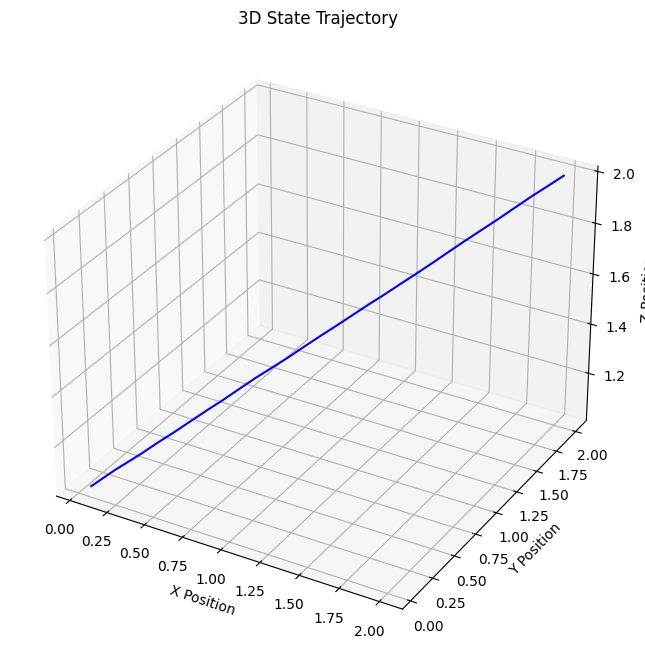

In [6]:
# Simple MPC
current_state = np.array([2.0, 2.0, 2.0])  # Destination state (adjust as needed)
#current_state = np.array([-338, 680,510])/1000
# Initial State
destination = np.array([0.0, 0.0, 1])  # Starting at the origin

# MPC Setup
x1 = cp.Variable((T+1, nx))
u1 = cp.Variable((T, nu))

# Simulation Setup
max_steps = 1000  # Max steps to simulate
states = [current_state.copy()]  # Track states over time
controls = []  # Track controls over time
iteration_times = []  # List to store the duration of each iteration

for step in range(max_steps):
    start_time = time.time()  # Record the start time of the iteration

    # Constraints and Objective setup for each step
    constraints = [x1[0] == (current_state-destination)]  # initial condition now uses current state
    constraints += [x1[k+1] == x1[k] + dt * u1[k] for k in range(T)]  # dynamics
    constraints += [cp.norm(u1[k], 2) <= 1 for k in range(T)]  # control constraint

    # Objective
    objective = cp.Minimize(sum(cp.quad_form(x1[k], Q) + cp.quad_form(u1[k], R) for k in range(T)))

    # Problem definition
    prob = cp.Problem(objective, constraints)

    # Solve MPC
    result = prob.solve(warm_start=True)


    # Apply the first control input
    optimal_control = u1.value[0, :]
    controls.append(optimal_control)

    # Update the state based on the first control input
    current_state = update(current_state,optimal_control,dt)
    states.append(current_state.copy())

    # Record the end time of the iteration
    end_time = time.time()
    iteration_time = end_time - start_time  # Calculate the duration of the iteration
    iteration_times.append(iteration_time)  # Store the time for analysis

    print(optimal_control)
    # Check if destination is reached
    if np.linalg.norm(current_state - destination) < 0.1:
        print("Destination reached.")
        break

print("Average iteration time:", np.mean(iteration_times), "seconds")
print("Total time for all iterations:", sum(iteration_times), "seconds")

# Create a new figure for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract X, Y, Z coordinates
X = [state[0] for state in states]
Y = [state[1] for state in states]
Z = [state[2] for state in states]

# Plot the trajectory in 3D
ax.plot(X, Y, Z, linestyle='-', color='b')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Set plot title and labels
ax.set_title('3D State Trajectory')

# Show the plot
plt.show()


The system is controllable.


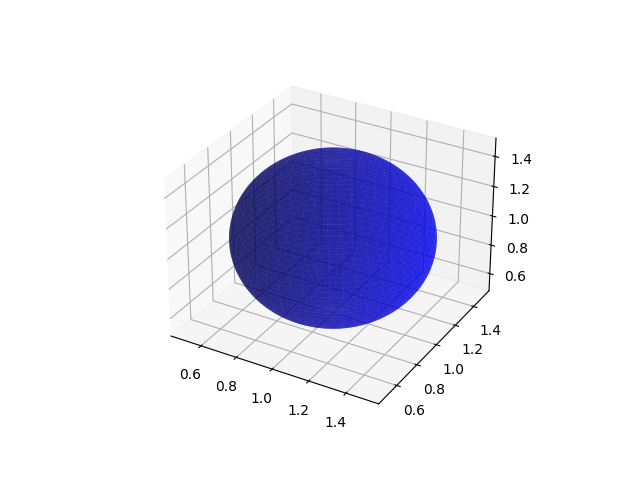

In [35]:
def z2xu(z,n,m,T):
    x_st = z[:n*T]
    u_st = z[n*T:]

    X = x_st.reshape((T, n)).T
    U = u_st.reshape((T-1, m)).T
    return X,U

def xu2z(X,U):
    x_stacked = X.T.reshape(-1)
    u_stacked = U.T.reshape(-1)
    z=np.hstack((x_stacked,u_stacked))  #initial z
    return z

######################################################################
n=nx
m=nu
#T=len(states)
N = m*(T - 1) + n*T
Ncon = n*(T-1) + T+T-1

A=np.eye(3)
B=dt*np.eye(3)

C=B
n = A.shape[0]
for i in range(1, n):
    C = np.hstack((C, np.linalg.matrix_power(A, i) @ B))

# Check the rank of the controllability matrix
rank_C = np.linalg.matrix_rank(C)

if rank_C == n:
    print("The system is controllable.")
else:
    print("The system is not controllable.")

#######################################################################


#######################################################################

centre = [1.0, 1.0, 1.0]
a = 0.5  # Radius for x


# Define theta and phi angles
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi, 100)

# Create the grid of angles
theta, phi = np.meshgrid(theta, phi)

# Sphere equations
xe = centre[0] + a * np.sin(phi) * np.cos(theta)
ye = centre[1] + a * np.sin(phi) * np.sin(theta)
ze = centre[2] + a * np.cos(phi)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xe, ye, ze, color='b', alpha=0.6)
plt.show()


In [60]:

def z_bar(z, j):
    y = cp.Variable(shape=z.shape)
    x = y[:n*T]
    u = y[n*T:]
    

    objective = cp.Minimize(cp.norm(y - z, 2))
    
    if j < n * (T - 1):
        t = int(j / n)
        x_t = x[n*t:n*(t + 1)]
        x_tp1 = x[n*(t + 1):n*(t + 2)]
        u_t = u[m*t:m*(t + 1)]
        gv = A @ x_t + B @ u_t  - x_tp1 #<---------------------Removed +x_t from here, wasnot making sense
        const = [gv[np.mod(j,n)] <= 0]
        
    elif j>=n*(T-1) and j < n*(T-1) + T:
        #print('hihihi')
        t = j - n*(T - 1)
        x = y[:n*T]
        x_t = x[n*t:n*(t + 1)]
        const = [(x_t[0] - centre[0]) ** 2 + (x_t[1] - centre[1]) ** 2 + (x_t[2] - centre[2]) ** 2 - a**2 <= 0]

    else:
        t = j - n*(T - 1) - T
        u = y[n*T:]
        u_t = u[n*t:n*(t + 1)]
        const = [1 - (u_t[0] ) ** 2 - (u_t[1]) ** 2 - (u_t[2]) ** 2  >= 0]
    
    prb = cp.Problem(objective, const)
    prb.solve()
    #print(prb.value)
    
    return y.value


def gfun(y, A, B, T, n, m):
    x = y[:n*T]
    u = y[n*T:]

    out=0
    for t in range(T-1):
        x_t = x[n*t:n*(t + 1)]
        x_tp1 = x[n*(t + 1):n*(t + 2)]
        u_t = u[m*t:m*(t + 1)]
        gi = A @ x_t + B @ u_t  - x_tp1#<---------------------Removed +x_t from here, wasnot making sense, because my A is already discrete
        out+=cp.norm(gi,1)
    return out

def grad_g_t(y, t):
    out = np.zeros((n,N))
    out[:, n*t:n*(t + 1)] = A 
    out[:, n*(t + 1):n*(t + 2)] = -np.eye(n)
    out[:, n*T + m*t: n*T + m*(t + 1)] = B
    return out

def grad_h1_t(y, t):
    out = np.zeros(N)
    x = y[:n*T]
    x_t = x[n*t:n*t+3]
    out[n*t:n*t+3] = 2*(x_t - centre)
    return out

def grad_h2_t(y, t):
    out = np.zeros(N)
    u = y[n*T:]
    u_t = u[n*t:n*t+3]
    out[n*T + m*t: n*T + m*(t + 1)] = -2*u_t
    return out

def grad_q_j(y, j):
    if j < n*(T - 1):
        t = int(j/n) 
        out = grad_g_t(y, t)
        out = out[np.mod(j,n), :]
    elif j>=n*(T-1) and j < n*(T-1) + T:
        t = j - n*(T - 1)
        out = grad_h1_t(y, t)
    else:
        t = j - n*(T - 1) - T
        out = grad_h2_t(y,t)
    return out



In [20]:

#######################################################################


x_stacked = np.concatenate(states)
u_stacked = np.concatenate(controls)
z=np.hstack((x_stacked,u_stacked))  #initial z

Xinit,Unit = z2xu(z,n,m,T)

for it in range(20):
    y2=cp.Variable(N)

    lbda=1
    gn=gfun(y2,A,B,T,n,m)
    Objective2=cp.Minimize(cp.norm(y2[n*T:],2)+lbda*gn+5*cp.norm(y2[n*T-6:n*T-3],2))#<------------Check this!
    constraint2 = [
            y2[0] == x_stacked[0],
            y2[1] == x_stacked[1],
            y2[2] == x_stacked[2],
        ]


    for j in range(Ncon):
        #print(j)
        z_bar_j = z_bar(z, j)
        #print(z_bar_j[0])
        dq_j = grad_q_j(z_bar_j, j)
        constraint2.append(dq_j@(y2 - z_bar_j) >= 0)
        #if j==495:
        #Xn,Un = z2xu(z_bar_j,n,m,T)
        #plt.scatter(Xn[0,:],Xn[1,:])
    
    #plt.show()

    


    problem2 = cp.Problem(Objective2,constraint2)
    problem2.solve()
    z_new=y2.value
    print(np.linalg.norm(z_new-z,2))
    if np.linalg.norm(z_new-z,2)<0.01:
        print("Converged")
        break
    z=z_new
    #print("z:",z)
    print("it:",it)
    Xn,Un = z2xu(z_new,n,m,T)
    #plt.plot(xe,ye,color='black')
    #plt.scatter(Xn[0,:],Xn[1,:])
    #plt.show()

#print(z_new.shape)


Xn,Un = z2xu(z_new,n,m,T)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(Xn[0, :], Xn[2, :], Xn[2, :])
ax.plot_surface(xe, ye, ze, color='r', alpha=0.6)

# Set labels
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set title
ax.set_title('3D Trajectory of Points Over Time')

# Show the plot
plt.show()


ValueError: cannot reshape array of size 120 into shape (4,3)

Converged
Average iteration time: 0.11716550046747382 seconds
Total time for all iterations: 3.8664615154266357 seconds


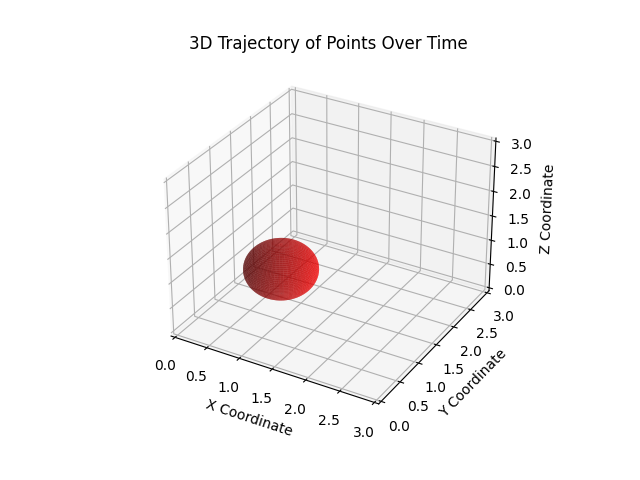

In [95]:

T=5
N = m*(T - 1) + n*T
Ncon = n*(T-1) + T+T-1

current_state = np.array([2.0, 2.0, 2.0])  # Destination state (adjust as needed)
destination = np.array([0.0, 0.0, 0])  # Starting at the origin

optimal_control = -current_state/np.linalg.norm(current_state)

Xstate = []
Ucontrol = []
iteration_times = []  # List to store the duration of each iteration
Xstate.append(current_state)
for it in range(100):
    start_time = time.time()  # Record the start time of the iteration
    states = np.zeros((T, 3))  # Adjusted for 3 dimensions
    states[0] = current_state
    control = np.zeros_like(optimal_control)
    control[2] = -0.5
    for k in range(1, T):
        states[k] = states[k-1] + control * dt
    flattened_states = states.flatten()
    repeated_controls = np.tile(optimal_control, (T-1, 1)).flatten()
    z = np.concatenate([flattened_states, repeated_controls])

    y2=cp.Variable(N)

    lbda=1
    gn=gfun(y2,A,B,T,n,m)
    #print(gn)
    Objective2=cp.Minimize(cp.norm(y2[n*T-3:n*T],2)+lbda*gn+0.05*cp.norm(y2[n*T:],2))#<------------Check this!(cp.norm(y2[n*T:],2)+lbda*gn + cp.norm(y2[n*T-3:n*T],2))
    constraint2 = [
            y2[0] == z[0],
            y2[1] == z[1],
            y2[2] == z[2],
        ]


    for j in range(Ncon):
        #print(j)
        z_bar_j = z_bar(z, j)
        #print(z_bar_j[0])
        dq_j = grad_q_j(z_bar_j, j)
        constraint2.append(dq_j@(y2 - z_bar_j) >= 0)

    
    #plt.show()

    problem2 = cp.Problem(Objective2,constraint2)
    problem2.solve()
    z_new=y2.value
    #Xn,Un = z2xu(z_new,n,m,T)
    #Un=Un.T
    optimal_control = z_new[n*T:n*T+m]
    #print(z_new[n*T:n*T+m]-optimal_control)
    current_state = update(current_state,optimal_control,dt)
    #print(np.linalg.norm(optimal_control))
    #print(current_state)
    Xstate.append(current_state)
    Ucontrol.append(optimal_control)
    # Record the end time of the iteration
    end_time = time.time()
    iteration_time = end_time - start_time  # Calculate the duration of the iteration
    iteration_times.append(iteration_time)  # Store the time for analysis

    #print(np.linalg.norm(destination-current_state,2))
    if np.linalg.norm(destination-current_state,2)<0.5:
        print("Converged")
        break
    #print("z:",z)
    #print("it:",it)
    
    #plt.plot(xe,ye,color='black')
    #plt.scatter(Xn[0,:],Xn[1,:])
    #plt.show()

#print(z_new.shape)
print("Average iteration time:", np.mean(iteration_times), "seconds")
print("Total time for all iterations:", sum(iteration_times), "seconds")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract X, Y, Z coordinates
Xp = [state[0] for state in Xstate]
Yp = [state[1] for state in Xstate]
Zp = [state[2] for state in Xstate]

# Plot the trajectory
ax.plot(Xp, Yp, Zp)
ax.plot_surface(xe, ye, ze, color='r', alpha=0.6)

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_zlim(0, 3)


# Set labels
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set title
ax.set_title('3D Trajectory of Points Over Time')

# Show the plot
plt.show()


In [93]:
Un

array([[-0.19301216, -0.3283994 , -0.42809464],
       [-0.19302342, -0.32840924, -0.42810344],
       [-0.19303251, -0.32841738, -0.42811087],
       [-0.19303971, -0.32842396, -0.42811699],
       [-0.19304506, -0.32842895, -0.42812171],
       [-0.19304868, -0.32843239, -0.42812502],
       [-0.19305087, -0.32843452, -0.42812709],
       [-0.19305229, -0.32843592, -0.42812847],
       [-0.1930541 , -0.32843772, -0.42813027]])